In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from IPython.display import display as dp
from helper import *
import phik
from phik import resources, report
from sklearn.impute import KNNImputer
import joblib
from scipy import stats


sns.set_style("darkgrid")

### Data Loading

In [2]:
df = pd.read_csv("./healthcare-dataset-stroke-data.csv",
                 index_col="id").sort_index()

In [3]:
dp(df.head())
bprint("shape")
df.shape

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
67,Female,17.0,0,0,No,Private,Urban,92.97,NaN,formerly smoked,0
77,Female,13.0,0,0,No,children,Rural,85.81,18.6,Unknown,0
84,Male,55.0,0,0,Yes,Private,Urban,89.17,31.5,never smoked,0
91,Female,42.0,0,0,No,Private,Urban,98.53,18.5,never smoked,0
99,Female,31.0,0,0,No,Private,Urban,108.89,52.3,Unknown,0



shape


(5110, 11)

In [4]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

📊 Cosmetic adjustment: convert all data to slug case

In [5]:
# convert column names
df.columns = [i.lower() for i in df.columns]
object_type_cols = df.select_dtypes("object").columns

# if col is object type, convert data
for col in df.columns:
    if col in object_type_cols:
        df[col] = df[col].apply(lambda i: "_".join(i.lower().split(" ")))

df["ever_married"] = df.ever_married.apply(lambda i: 0 if i == "no" else 1)
df["is_female"] = df.gender.apply(lambda i: 0 if i == "male" else 1)
df["lives_urban"] = df.residence_type.apply(lambda i: 0 if i == "rural" else 1)
df = df.drop(columns=["residence_type"])

df.head(1)

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke,is_female,lives_urban
id,,,,,,,,,,,,
67,female,17.0,0,0,0,private,92.97,NaN,formerly_smoked,0,1,1


📊 Check the unique values in categorial columns for anamolies:

In [6]:
cat_cols = object_type_cols.tolist() + [
    "is_female",
    "lives_urban",
    "hypertension",
    "heart_disease",
    "stroke",
]
num_cols = [i for i in df.columns if i not in cat_cols]
for col in df.columns:
    if col in cat_cols:
        dp(pd.DataFrame(df[col].value_counts()))

,count
gender,
female,2994
male,2115
other,1


,count
hypertension,
0,4612
1,498


,count
heart_disease,
0,4834
1,276


,count
ever_married,
1,3353
0,1757


,count
work_type,
private,2925
self-employed,819
children,687
govt_job,657
never_worked,22


,count
smoking_status,
never_smoked,1892
unknown,1544
formerly_smoked,885
smokes,789


,count
stroke,
0,4861
1,249


,count
is_female,
1,2995
0,2115


,count
lives_urban,
1,2596
0,2514


📝 Categorial Features: 

Most categorial columns have categories that are easy to interpret. \
There's 2 exceptions: 

1. more than 1/3 `unknown` in smoking_status column.
- Is unknown a sort of null, should it be treated equally like the other categories ?

> Decide on how to deal with this after EDA

2. one `other` gender in genders.
> We would drop this as it is just one row (no disrespect). 

Decide on how to encode the columns after EDA.

Drop 1 `other` gender row:

In [7]:
gender_other_id = df.loc[df.gender == "other"].index[0]
df = df.drop(gender_other_id)
df = df.drop(columns=["gender"])


assert df.shape[0] == 5109

In [8]:
df.head(1)

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke,is_female,lives_urban
id,,,,,,,,,,,
67,17.0,0,0,0,private,92.97,NaN,formerly_smoked,0,1,1


In [9]:
# redifne cat_cols and num_cols
cat_cols = df.select_dtypes("object").columns.tolist() + [
    "is_female",
    "ever_married",
    "lives_urban",
    "hypertension",
    "heart_disease",
    "stroke",
]
num_cols = [i for i in df.columns if i not in cat_cols]

📊 Investigate numerical columns variable distribution

In [10]:
df.describe().style.apply(mark_df_color, id=1)

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,is_female,lives_urban
count,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,4908.000000,5109.000000,5109.000000,5109.000000
mean,43.229986,0.097475,0.054022,0.656293,106.140399,28.894560,0.048738,0.586025,0.508123
std,22.613575,0.296633,0.226084,0.474991,45.285004,7.854320,0.215340,0.492592,0.499983
min,0.080000,0.000000,0.000000,0.000000,55.120000,10.300000,0.000000,0.000000,0.000000
25%,25.000000,0.000000,0.000000,0.000000,77.240000,23.500000,0.000000,0.000000,0.000000
50%,45.000000,0.000000,0.000000,1.000000,91.880000,28.100000,0.000000,1.000000,1.000000
75%,61.000000,0.000000,0.000000,1.000000,114.090000,33.100000,0.000000,1.000000,1.000000
max,82.000000,1.000000,1.000000,1.000000,271.740000,97.600000,1.000000,1.000000,1.000000


📝 Numerical data types: 

- `binary`: hypertension, heart_disease, stroke
- `discrete`: age
- `continuous`: avg_glucose_level, bmi

From the mean in stroke, we see that: 
> only 5% of people has stroke in this dataset. \
> the target class is highly imbalanced.



### Data Cleaning
Null and duplication detection

In [11]:
bprint("duplication count:")
df.duplicated().sum()

# duplication edge cases: same features, diff dependent vars.


duplication count:


0

In [12]:
bprint("null count:")
dp(df.isnull().sum())


null count:


age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
is_female              0
lives_urban            0
dtype: int64

📝 only bmi column has null values, 201 null values.

📊 Take a closer look into rows with null in bmi:

In [13]:
bmi_nulls = df.loc[df.bmi.isnull()]
bprint("Summary: bmi null")
dp(bmi_nulls.describe().style.apply(mark_df_color, id=1, color="salmon"))

bprint("Summary: all data")
dp(df.describe().style.apply(mark_df_color, id=1))


Summary: bmi null


,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,is_female,lives_urban
count,201.000000,201.000000,201.000000,201.000000,201.000000,0.000000,201.000000,201.000000,201.000000
mean,52.049154,0.233831,0.164179,0.741294,126.724627,nan,0.199005,0.482587,0.527363
std,22.276181,0.424323,0.371363,0.439017,59.240322,nan,0.400249,0.500944,0.500497
min,0.480000,0.000000,0.000000,0.000000,57.520000,nan,0.000000,0.000000,0.000000
25%,37.000000,0.000000,0.000000,0.000000,81.430000,nan,0.000000,0.000000,0.000000
50%,58.000000,0.000000,0.000000,1.000000,99.870000,nan,0.000000,0.000000,1.000000
75%,71.000000,0.000000,0.000000,1.000000,191.790000,nan,0.000000,1.000000,1.000000
max,82.000000,1.000000,1.000000,1.000000,260.850000,nan,1.000000,1.000000,1.000000



Summary: all data


,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,is_female,lives_urban
count,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,4908.000000,5109.000000,5109.000000,5109.000000
mean,43.229986,0.097475,0.054022,0.656293,106.140399,28.894560,0.048738,0.586025,0.508123
std,22.613575,0.296633,0.226084,0.474991,45.285004,7.854320,0.215340,0.492592,0.499983
min,0.080000,0.000000,0.000000,0.000000,55.120000,10.300000,0.000000,0.000000,0.000000
25%,25.000000,0.000000,0.000000,0.000000,77.240000,23.500000,0.000000,0.000000,0.000000
50%,45.000000,0.000000,0.000000,1.000000,91.880000,28.100000,0.000000,1.000000,1.000000
75%,61.000000,0.000000,0.000000,1.000000,114.090000,33.100000,0.000000,1.000000,1.000000
max,82.000000,1.000000,1.000000,1.000000,271.740000,97.600000,1.000000,1.000000,1.000000


📝 Data summary of all data v.s. bmi null data \
As can see in the comparison, \
`data with missing bmi has circa 4 times higher chance to have stroke`. \
All the stroke related risk factor features in this group of people is also higher.

> This gives us a better idea on how to impute the data afterwards, using mean or \
> median is obviously not the right approach.

# EDA

📊 Numerical features distribution

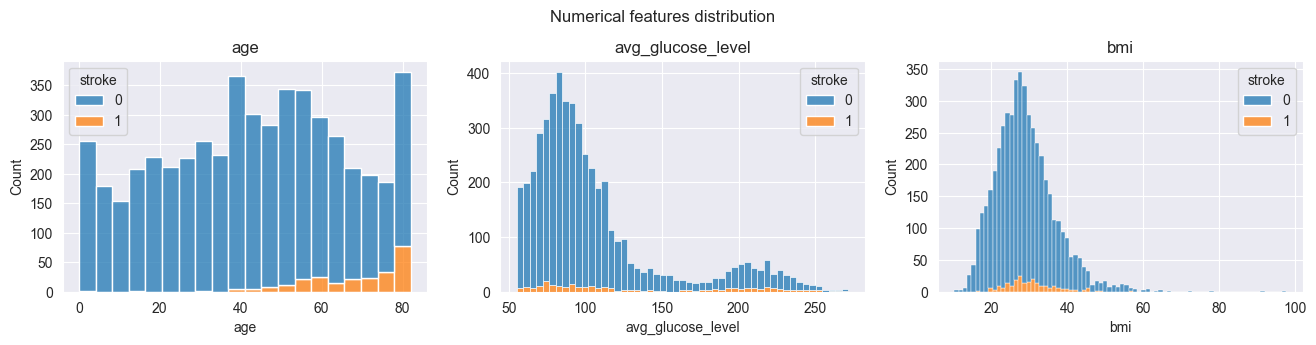

In [14]:
n = 1
fig_size(16, 3)
for i in num_cols:
    plt.subplot(1, 3, n)
    sns.histplot(data=df, x=i, hue="stroke", multiple="stack")
    plt.title(i)
    n += 1
plt.suptitle("Numerical features distribution", y=1.05)
plt.show()

📝 numerical features distribution

`age` 
-  age distribution is universal with some central tendency and higher population \
on both tails. 

- People over 40 have higher chance to have stroke, the chance increases with \
the increase of age. Stroke seems to only occur after age 40.


`avg_glucose_level` 
- avg_glucose_level is right skewed, with majority of people in the healthy \
avg_glucose range (70~100). There's a cluster of people with glucose \
level 200~250. 

`bmi` 
- bmi is a right skewed bell curve, the peak is at bmi around 30, which the \
healthy range is from 18.5 ~ 24.9 (as different age groups have different bmi \
standard, this is just for reference).

- We don't see a clear pattern between stroke and bmi here.

🤔 Bmi is not a good indicator for one's health level, as muscle weigh heavier \
than fat. But glucose level is a very good indicator, high glucose level is often \
related to heart diseases. 

According to [WHO](https://www.who.int/data/gho/indicator-metadata-registry/imr-details/2380), when one's glucose_level > 126 mg/dL, one is diagnosed as diabetic. \
While level 70mg/dL~ 100mg/dL is healthy glucose level.

Is this also the case in this dataset ?

`Hypothesis Testing`:

`H0`: People with glucose_level > 125 does not have higher stroke rate than ones with \
glucose_level < 125.

`Ha`: People with glucose_level > 125 have significantly higher stroke rate than \
ones with glucose_level < 125.

alpha: 0.05

=> Normality test, should use Mann and Whitney U test

In [16]:
high_glucose_stroke_rate = df.loc[df.avg_glucose_level > 125].stroke.tolist()
normal_glucose_stroke_rate = df.loc[df.avg_glucose_level <= 125].stroke.tolist(
)
alpha = 0.05
t_statistic, p_value = stats.ttest_ind(
    high_glucose_stroke_rate, normal_glucose_stroke_rate, alternative="greater"
)
bprint("Results: ")
print("T-statistic:", t_statistic)
print("P-value:", p_value)
bprint(f"P-value: {p_value} << alpha: {alpha}")
print(
    ">> People with glucose level > 125 has significantlly higher chance to get stroke comparing to ones < 126"
)


Results: 
T-statistic: 8.463188172157112
P-value: 1.679897900521088e-17

P-value: 1.679897900521088e-17 << alpha: 0.05
>> People with glucose level > 125 has significantlly higher chance to get stroke comparing to ones < 126


> High glucose level is a strong indicator for stroke, we can create a new \
feature later.

📊 Categorial feature distribution

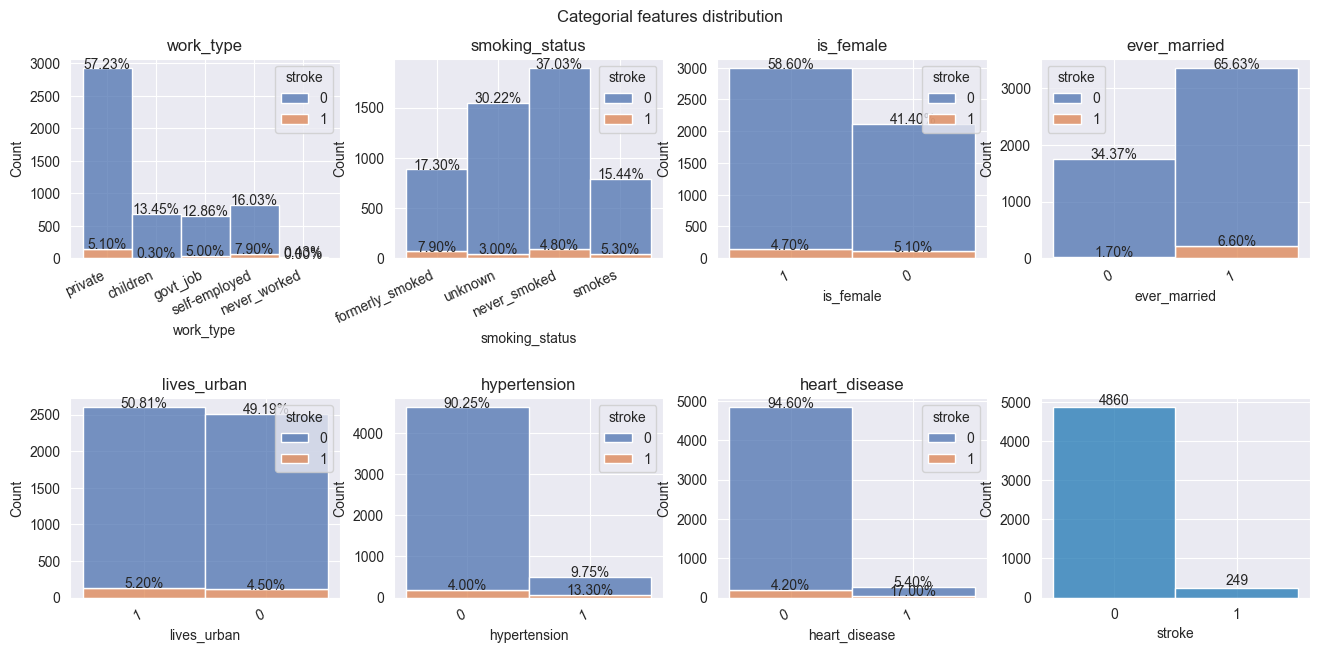

In [17]:
# plotting prep
cat_df = df.copy()
cat_df.is_female = cat_df.is_female.astype("str")
cat_df.lives_urban = cat_df.lives_urban.astype("str")
cat_df.ever_married = cat_df.ever_married.astype("str")
cat_df.hypertension = cat_df.hypertension.astype("str")
cat_df.heart_disease = cat_df.heart_disease.astype("str")
cat_df.stroke = cat_df.stroke.astype("str")


n = 1
fig_size(16, 7)
for i in cat_cols[:-1]:
    plt.subplot(2, 4, n)
    ax = sns.histplot(data=cat_df, x=i, hue="stroke",
                      multiple="stack", palette="deep")
    mark_percent(ax, cat_df[i], df.stroke, 1)
    plt.title(i)
    n += 1
    plt.subplots_adjust(hspace=0.7)
    plt.xticks(rotation=25, ha="right")
plt.subplot(2, 4, 8)
ax = sns.histplot(data=cat_df, x="stroke")
mark_bar(ax)
plt.suptitle("Categorial features distribution", y=0.95)
plt.show()

📝 categorial columns distribution 

- `stroke` target class is highly imbalanced
- `hypertension`, `heart_disease`: these obvious stroke risk factors are also \
highly imbalanced, and people with the risk factors are 3~4 times more likely \
to have stroke.
- `ever_married`: people that had ever married have more stroke, this might be \
due to older age.
- `smoking_status`: people that smoke or had smoked have higher chance to \
have stroke.
- `work_type`: people that never worked or have child-related work \
(might be housewives or housemen ) have lower chance to have stroke.   
- `residence_type` and `gender` do not have clear correlation with stroke.

📊 Correlations between features and target 

Now, let's observe the correlation between all features and target

As in this dataset, we have mixed data types, `Phik-correlation` is used, \
it works for mixed data types. \
And we use weak~moderate correlation coefficient 0.2 as threshold (we only \
show the correlated data.)

All the categorial features are one-hot encoded for correlation investigation.

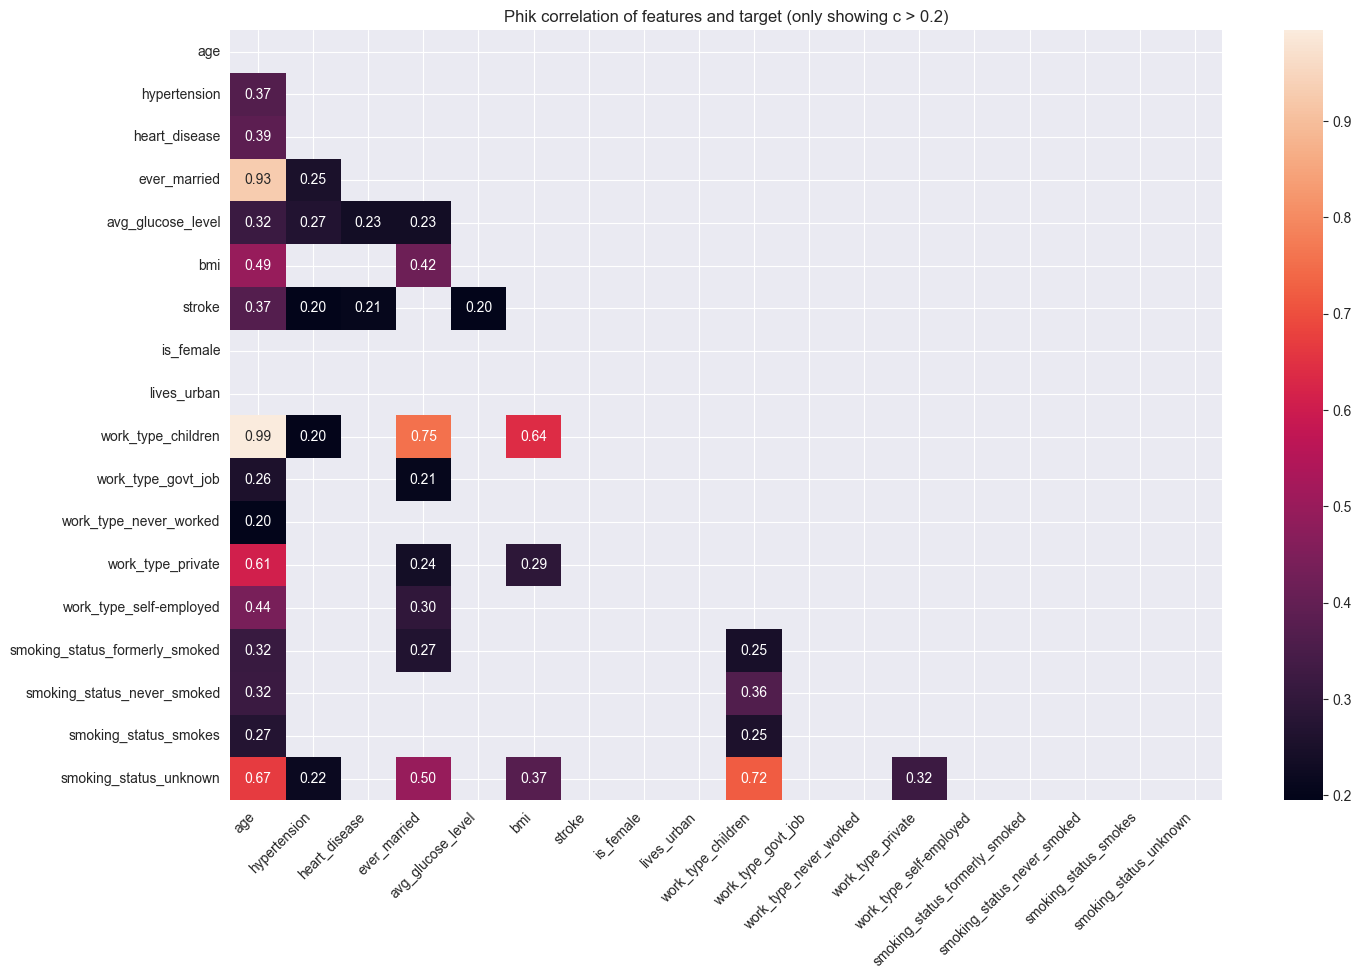

In [18]:
# onehot encode categorial features
df_corr = pd.get_dummies(df)
# phik correlation
phik_corr = df_corr.phik_matrix(interval_cols=num_cols)
fig_size(16, 10)

# don't show correlation among one-hot encoded columns
one_hot_cols_mask = pd.DataFrame(index=phik_corr.columns)
for col in phik_corr.columns:
    col_mask = [
        i.split("_")[0] == col.split("_")[0] for i in phik_corr[col].index.tolist()
    ]
    one_hot_cols_mask[col] = col_mask

# only show correlation > 0.2
corr_threshold_mask = phik_corr < 0.19
# triangle mask
triangle_mask = np.triu(phik_corr)
mask = corr_threshold_mask | one_hot_cols_mask | triangle_mask
sns.heatmap(phik_corr, annot=True, fmt=".2f", mask=mask)
plt.xticks(rotation=45, ha="right")
plt.title("Phik correlation of features and target (only showing c > 0.2)")
plt.show()

📝 Features and target correlation

Note: Many features show correlation with the whole one-hot encoded feature group, \
we need to take those with a grain of salt when interpreting.

`stroke` has the strongest correlation with `age`, followed by `hypertension` \
, `heart_disease` and `average_glucose_level`. 

> These can be combined into features.

Age has strong correlation to ever_married (older ppl) and \
work_type_children (kids).

The reason why married people have more stroke is most likely due to age. 

### Imputation

📊 Impute BMI

Based on EDA and domain knowledge, relevant features are selected for imputing \
bmi with KNNImputer.


In [19]:
# selected relevant features for bmi imputation
df_to_impute = df[["age", "avg_glucose_level", "bmi"]].copy()
df_to_impute["risk_factors"] = df.hypertension + df.heart_disease
index = df_to_impute.index.tolist()
# knn impute
imputer = KNNImputer(n_neighbors=2)

imputed_df = pd.DataFrame(
    imputer.fit_transform(df_to_impute), columns=df_to_impute.columns, index=index
)

df["bmi"] = imputed_df.bmi

### Feature Engineering

📊 Based on EDA and domain knowledge, we can create some new features:

1. `unhealthy_glucose_level`: 
we would use `glucose level > 126` as unhealthy_glucose_level 

2. `age_bmi_percentile`: healthy bmi definition is different for *different age groups*, \
thus here we get the percentile of the bmi of the person in the age group.

3. `healthy_smoke_habit`: 
- healthy: never_smoke | unknown
- unhealthy: formerly_smoked | smokes

4. `heart_disease_history`: heart_disease + hypertension

5. `unhealthy_bmi_glucose`: age_bmi > 75 percentile + unhealthy_glucose



In [20]:
# smoke habit
df["healthy_smoke_habit"] = df.smoking_status.apply(
    lambda i: (1 if (i == "never_smoked" or i == "unknown") else 0)
)
# heart disease
df["heart_diseases_history"] = (
    df.hypertension + df.heart_disease).astype("float")

# glucose level
df["unhealthy_glucose_level"] = df.avg_glucose_level.apply(
    lambda i: 1 if i > 125 else 0
)

In [21]:
# age group bmi percentile
df_bin = df.copy()
df_bin["age_bin"] = pd.cut(
    df.age,
    bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 150],
    labels=["<10", "10s", "20s", "30s", "40s", "50s", "60s", "70s", ">80"],
)

age_bmi_bin = pd.DataFrame(
    df_bin[["age_bin", "bmi"]].groupby("age_bin", observed=True).bmi.apply(list)
).T

age_bmi_percentile = []

for i in range(df.bmi.shape[0]):
    age_bin_ls = df_bin.age_bin.tolist()
    bmi_list = df_bin.bmi.tolist()

    age_bmi_list = age_bmi_bin[age_bin_ls[i]].tolist()[0]
    bmi_percentile = stats.percentileofscore(age_bmi_list, bmi_list[i])
    age_bmi_percentile.append(bmi_percentile)

df["age_bmi_percentile"] = age_bmi_percentile

In [22]:
df_bmi_glucose = df.copy()
df_bmi_glucose["bmi_over_75"] = df_bmi_glucose.age_bmi_percentile.apply(
    lambda i: i >= 75
)
df["unhealthy_bmi_glucose"] = (
    df_bmi_glucose.bmi_over_75 & df_bmi_glucose.unhealthy_glucose_level
).astype("int")

In [23]:
bprint("new features:")
df.head(5)[
    [
        "healthy_smoke_habit",
        "heart_diseases_history",
        "unhealthy_glucose_level",
        "age_bmi_percentile",
        "unhealthy_bmi_glucose",
    ]
]


new features:


,healthy_smoke_habit,heart_diseases_history,unhealthy_glucose_level,age_bmi_percentile,unhealthy_bmi_glucose
id,,,,,
67,0,0.0,0,90.733591,0
77,1,0.0,0,10.135135,0
84,1,0.0,0,55.285541,0
91,1,0.0,0,0.405954,0
99,1,0.0,0,98.961424,0


In [24]:
df.head(1)

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke,is_female,lives_urban,healthy_smoke_habit,heart_diseases_history,unhealthy_glucose_level,age_bmi_percentile,unhealthy_bmi_glucose
id,,,,,,,,,,,,,,,,
67,17.0,0,0,0,private,92.97,33.95,formerly_smoked,0,1,1,0,0.0,0,90.733591,0


In [25]:
joblib.dump(df, "./stroke_modeling.csv")

['./stroke_modeling.csv']

💡 This is the end of data cleaning + EDA + feature engineering. 

For the modeling part of the project go to `project_modeling.ipynb` notebook.